## Crack Segmentation
0. Configuring the Development Environment
1. Preparing Dataset
2. Defining Classes and Functions
3. Training
4. Testing
5. Performing Inference

### 0. Configuring the Development Environment
* Virtual environment : deeplabv3p
* Python version : python 3.10
* Installation lists
    * !pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 -f https://download.pytorch.org/whl/torch_stable.html
    * opencv-python
    * pandas
    * random2
    * seaborn
    * !pip install numpy>=1.20.3
    * pip install albumentations
        * python3 -m pip install --user albumentations
        * !pip install -q -U segmentation-models-pytorch albumentations > /dev/null
    * timm==0.9.5
    * pretrainedmodels==0.7.4
    * !pip install segmentation-models-pytorch
* Segmentation_Pytorch Git Address: https://github.com/qubvel/segmentation_models.pytorch.git

### 1. Preparing the Dataset

In [1]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils as su

### Defining Train / Val / Test Directories

In [2]:
DATA_DIR = '/home/sh/Documents/deep-learning/crack-detection-deeplabv3p/dataset'

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_labels')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')

### Shortlist Specific Classes to Segment

In [3]:
# Get class names
class_names = ['background', 'crack']

# Get class RGB values
class_rgb_values = [[0,0,0], [255,255,255]] # select_class_rgb_values

class_idx = [0,1]                           # select_class_indices

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['background', 'crack']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


### Helper functions for viz. & one-hot encoding/decoding

In [4]:
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]);
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map

# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [5]:
class CracksDataset(torch.utils.data.Dataset):

    """Cracks Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """

    def __init__(
            self,
            images_dir,
            masks_dir,
            class_rgb_values=None,
            augmentation=None,
            preprocessing=None,
    ):

        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)

        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        # return length of
        return len(self.image_paths)

### Visualising sample image and mask

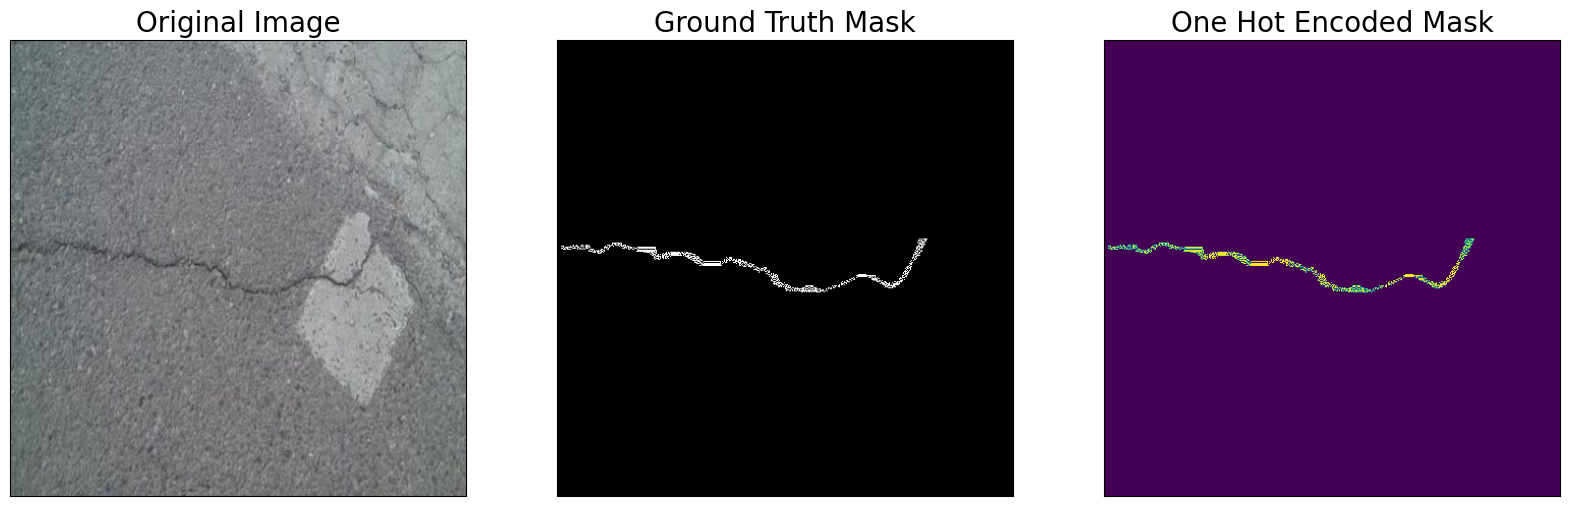

In [6]:
dataset = CracksDataset(x_train_dir, y_train_dir, class_rgb_values=class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[2]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

### Defining augmentations

In [7]:
def get_training_augmentation():
    train_transform = [
        album.RandomCrop(height=256, width=256, always_apply=True),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.75,
        ),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform
    Args:
        preprocessing_fn (callable): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))

    return album.Compose(_transform)

Visualise augmented images & masks

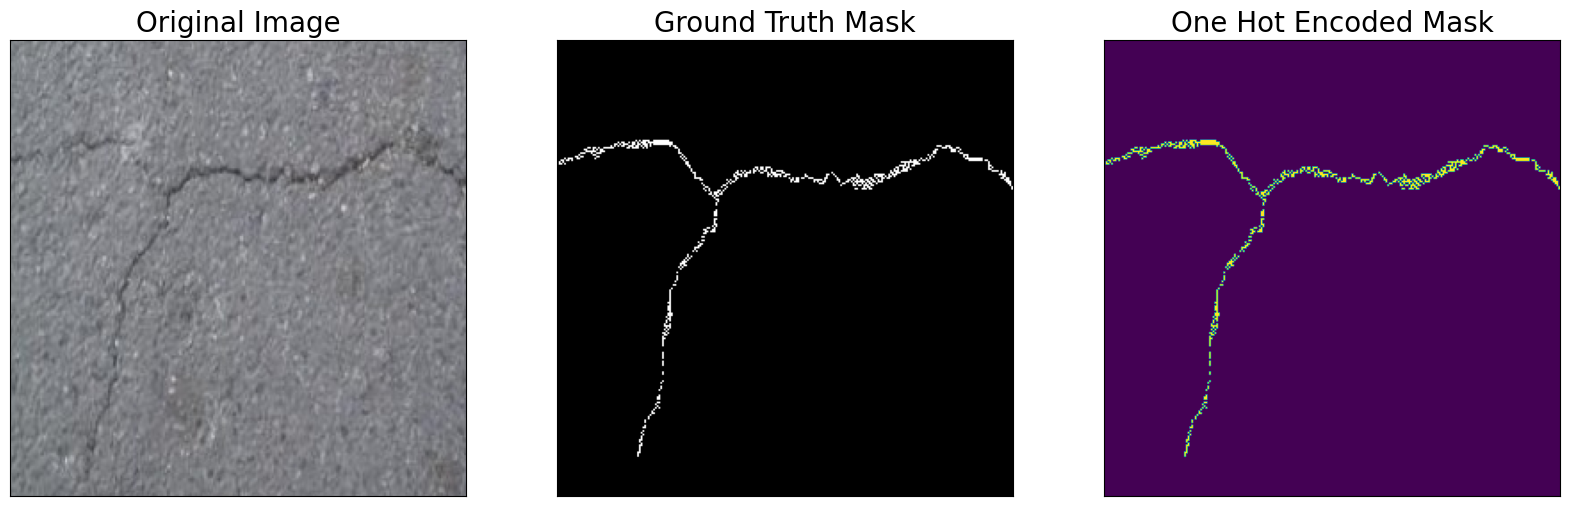

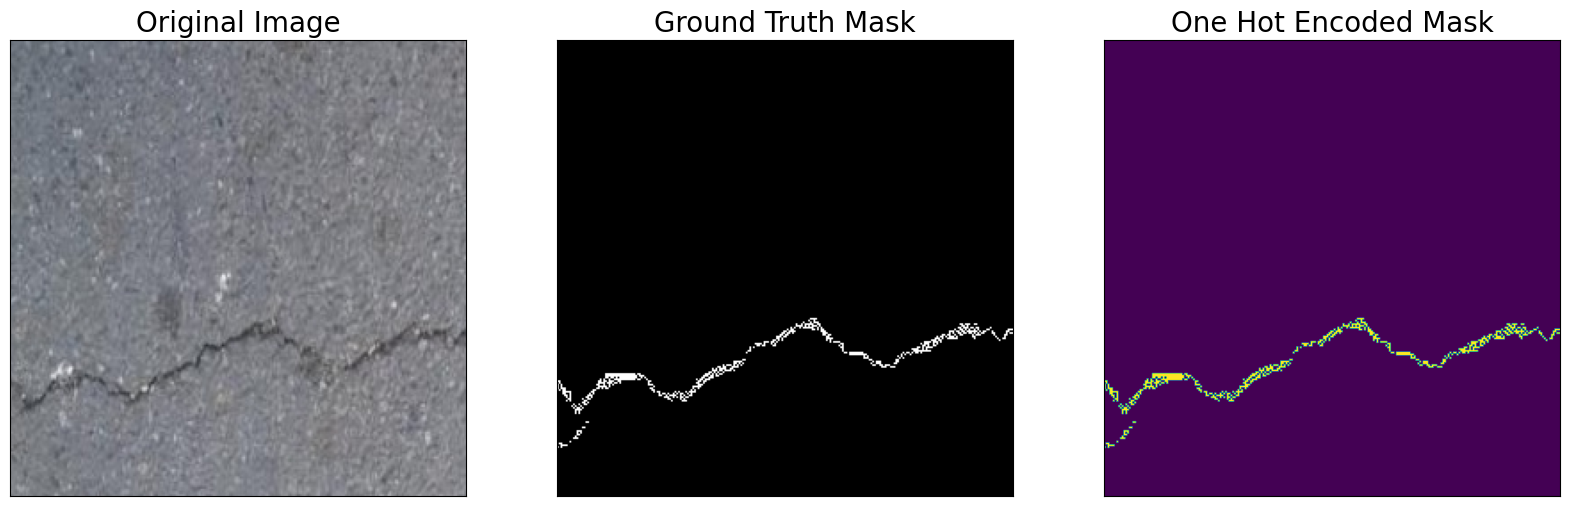

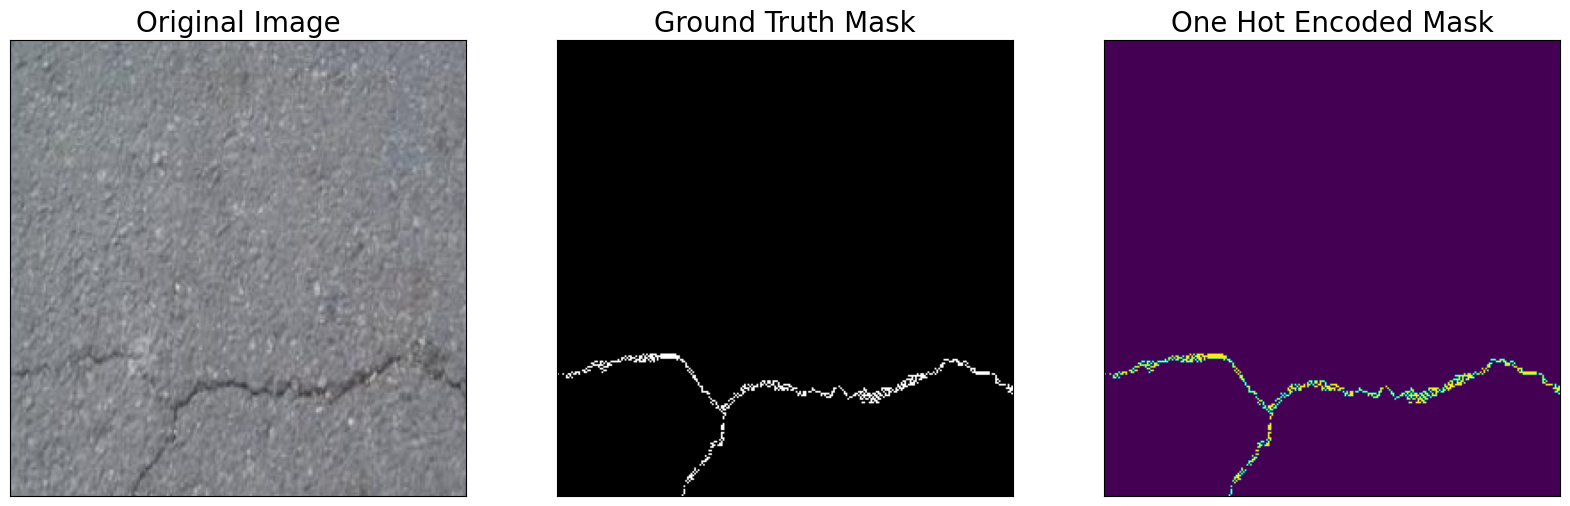

In [8]:
augmented_dataset = CracksDataset(
    x_train_dir, y_train_dir,
    augmentation=get_training_augmentation(),
    class_rgb_values=class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset)-1)

# Different augmentations on a random image/mask pair (256*256 crop)
for i in range(3):
    image, mask = augmented_dataset[random_idx]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

### Training DeepLabV3+ with Pretrained ResNet 101 Encoder

### Model definition

In [9]:
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = class_names
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

### Get train / val DataLoaders

In [10]:
# Get train and val dataset instances
train_dataset = CracksDataset(
    x_train_dir, y_train_dir,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=class_rgb_values,
)

valid_dataset = CracksDataset(
    x_valid_dir, y_valid_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=class_rgb_values,
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=5)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=2)

### Setting hyperparameters

In [11]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 80

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss = su.losses.DiceLoss()

# define metrics
metrics = [
    su.metrics.IoU(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.0001),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

# load best saved model checkpoint from previous commit (if present)
if os.path.exists('/content/drive/MyDrive/Colab Notebooks/Deeplabv3p/Deeplabv3p-Crack-Segmentation/output/best_model.pth'):
    model = torch.load('/content/drive/MyDrive/Colab Notebooks/Deeplabv3p/Deeplabv3p-Crack-Segmentation/output/best_model.pth', map_location=DEVICE)

In [12]:
train_epoch = su.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = su.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

### Training DeepLabV3+

In [13]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)
        # file_name = f'model_epoch_{i}.pth'
        # torch.save(model, os.path.join('./output', file_name))

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './output/best_model.pth')
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 11/11 [00:02<00:00,  4.29it/s, dice_loss - 0.9198, iou_score - 0.08831]
Model saved!

Epoch: 1
valid: 100%|██████████| 11/11 [00:02<00:00,  4.41it/s, dice_loss - 0.9137, iou_score - 5.044e-13]

Epoch: 2
valid: 100%|██████████| 11/11 [00:03<00:00,  3.51it/s, dice_loss - 0.9249, iou_score - 5.073e-13]

Epoch: 3
valid: 100%|██████████| 11/11 [00:02<00:00,  3.92it/s, dice_loss - 0.9673, iou_score - 4.995e-13]

Epoch: 4
valid: 100%|██████████| 11/11 [00:02<00:00,  3.86it/s, dice_loss - 0.7899, iou_score - 0.03]   

Epoch: 5
valid: 100%|██████████| 11/11 [00:02<00:00,  4.23it/s, dice_loss - 0.7133, iou_score - 0.3159]
Model saved!

Epoch: 6
valid: 100%|██████████| 11/11 [00:02<00:00,  4.12it/s, dice_loss - 0.7743, iou_score - 0.126] 

Epoch: 7
valid: 100%|██████████| 11/11 [00:02<00:00,  4.42it/s, dice_loss - 0.7991, iou_score - 0.1089]

Epoch: 8
valid: 100%|██████████| 11/11 [00:02<00:00,  4.47it/s, dice_loss - 0.7919, iou_score - 0.1155]

Epoch: 9
valid: 1

### Prediction on Test Data

In [14]:
# load best saved model checkpoint from the current run
if os.path.exists('/home/sh/Documents/deep-learning/crack-detection-deeplabv3p/output/best_model.pth'):
    best_model = torch.load('/home/sh/Documents/deep-learning/crack-detection-deeplabv3p/output/best_model.pth', map_location=DEVICE)
    print('Loaded DeepLabV3+ model from this run.')

# load best saved model checkpoint from previous commit (if present)
elif os.path.exists('/home/sh/Documents/deep-learning/crack-detection-deeplabv3p/best_model.pth'):
    best_model = torch.load('/home/sh/Documents/deep-learning/crack-detection-deeplabv3p/best_model.pth', map_location=DEVICE)
    print('Loaded DeepLabV3+ model from a previous commit.')

Loaded DeepLabV3+ model from this run.


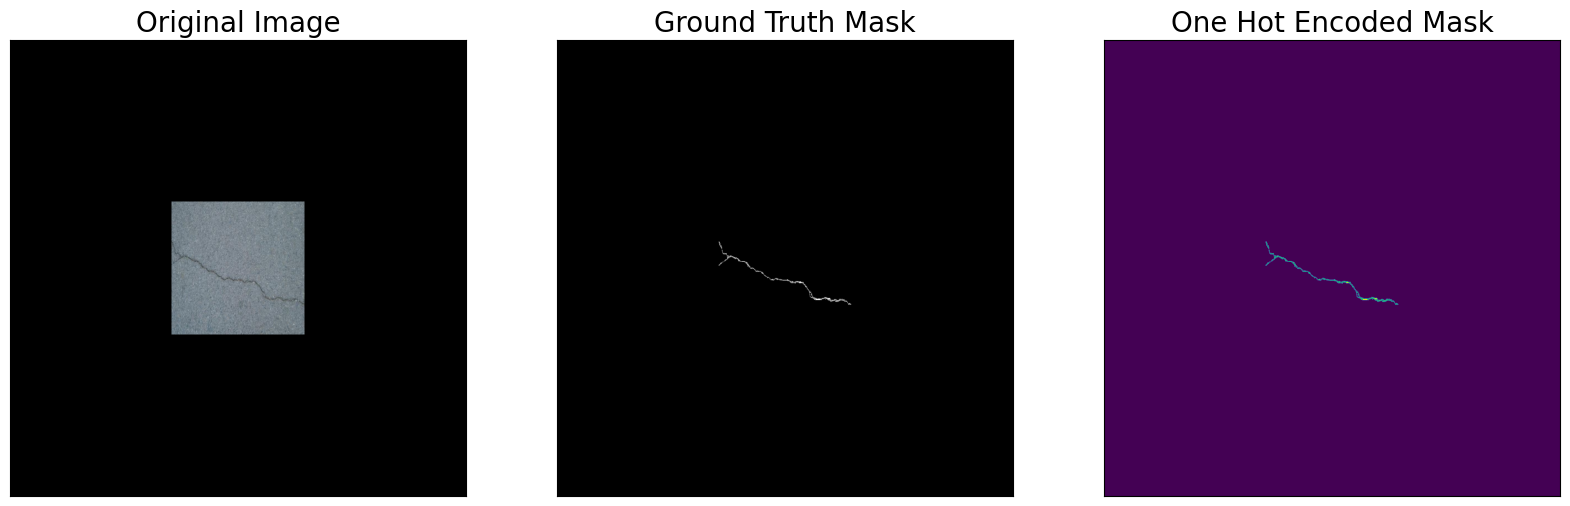

In [15]:
# create test dataloader (with preprocessing operation: to_tensor(...))
test_dataset = CracksDataset(
    x_test_dir,
    y_test_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

# test dataset for visualization (without preprocessing transformations)
test_dataset_vis = CracksDataset(
    x_test_dir, y_test_dir,
    augmentation=get_validation_augmentation(),
    class_rgb_values=class_rgb_values,
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)


In [16]:
# Center crop padded image / mask to original image dims
def crop_image(image, target_image_dims=[448,448,3]):

    target_size = target_image_dims[0]
    image_size = len(image)
    padding = (image_size - target_size) // 2

    return image[
        padding:image_size - padding,
        padding:image_size - padding,
        :,
    ]

In [17]:
sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

Generating predictions for image 0...


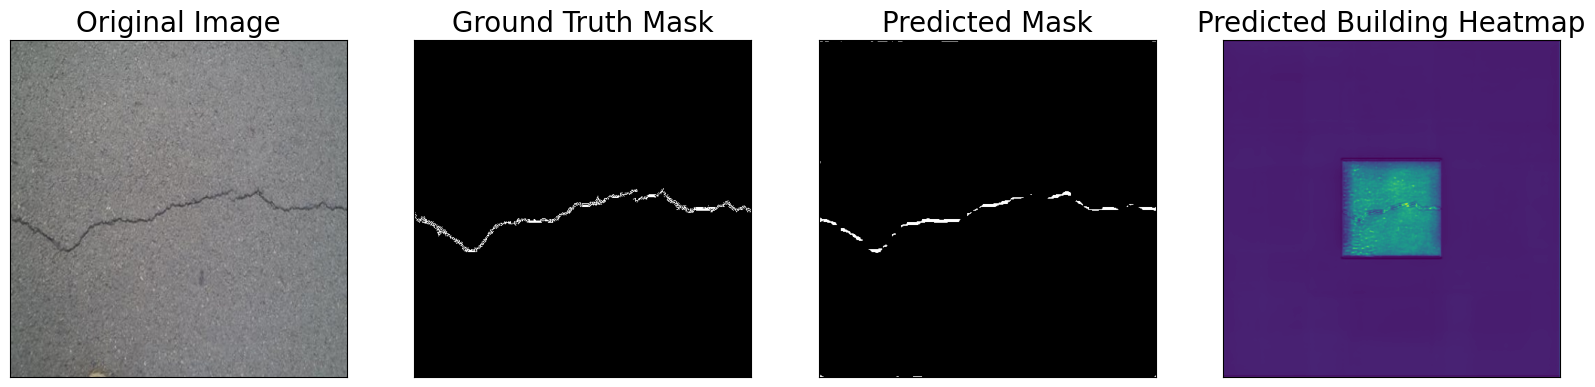

Generating predictions for image 1...


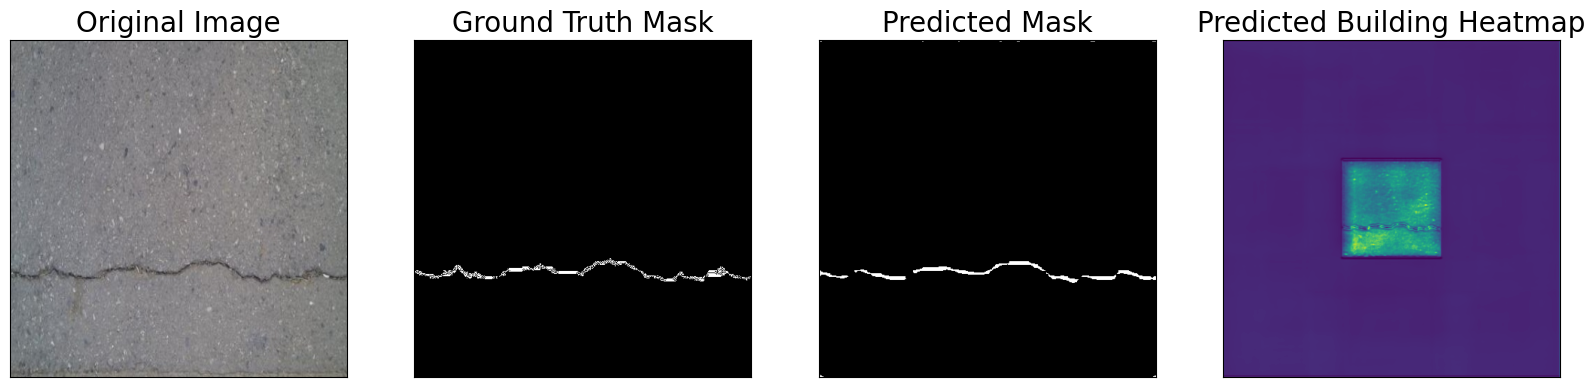

Generating predictions for image 2...


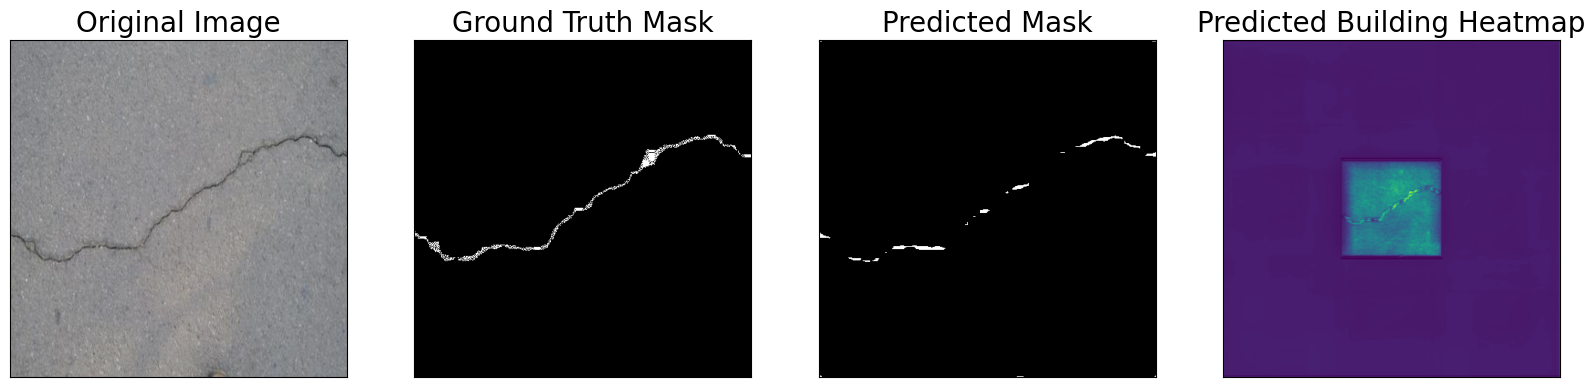

In [23]:
for idx in range(len(test_dataset)):
    if  idx < 3:
        print(f'Generating predictions for image {idx}...')
        image, gt_mask = test_dataset[idx]
        image_vis = crop_image(test_dataset_vis[idx][0].astype('uint8'))
        x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
        # Predict test image
        pred_mask = best_model(x_tensor)
        pred_mask = pred_mask.detach().squeeze().cpu().numpy()
        # Convert pred_mask from `CHW` format to `HWC` format
        pred_mask = np.transpose(pred_mask,(1,2,0))
        # Get prediction channel corresponding to building
        pred_building_heatmap = pred_mask[:,:,class_names.index('crack')]
        pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), class_rgb_values))
        # Convert gt_mask from `CHW` format to `HWC` format
        gt_mask = np.transpose(gt_mask,(1,2,0))
        gt_mask = crop_image(colour_code_segmentation(reverse_one_hot(gt_mask), class_rgb_values))
        cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])

        visualize(
            original_image = image_vis,
            ground_truth_mask = gt_mask,
            predicted_mask = pred_mask,
            predicted_building_heatmap = pred_building_heatmap
        )
    elif idx == 3:
        break

In [19]:
test_epoch = su.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

valid: 100%|██████████| 11/11 [00:07<00:00,  1.54it/s, dice_loss - 0.1215, iou_score - 0.9534]
Evaluation on Test Data: 
Mean IoU Score: 0.9534
Mean Dice Loss: 0.1215


In [20]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
dice_loss,0.470174,0.419185,0.375587,0.342077,0.316046,0.293904,0.278022,0.258864,0.243523,0.229639,...,0.053082,0.051148,0.052630,0.050462,0.052211,0.051566,0.049947,0.049234,0.049715,0.049016
iou_score,0.550618,0.803191,0.877719,0.913572,0.926971,0.931742,0.932918,0.936969,0.935342,0.937436,...,0.944162,0.946207,0.943528,0.946041,0.942456,0.942393,0.944712,0.944739,0.943548,0.943479


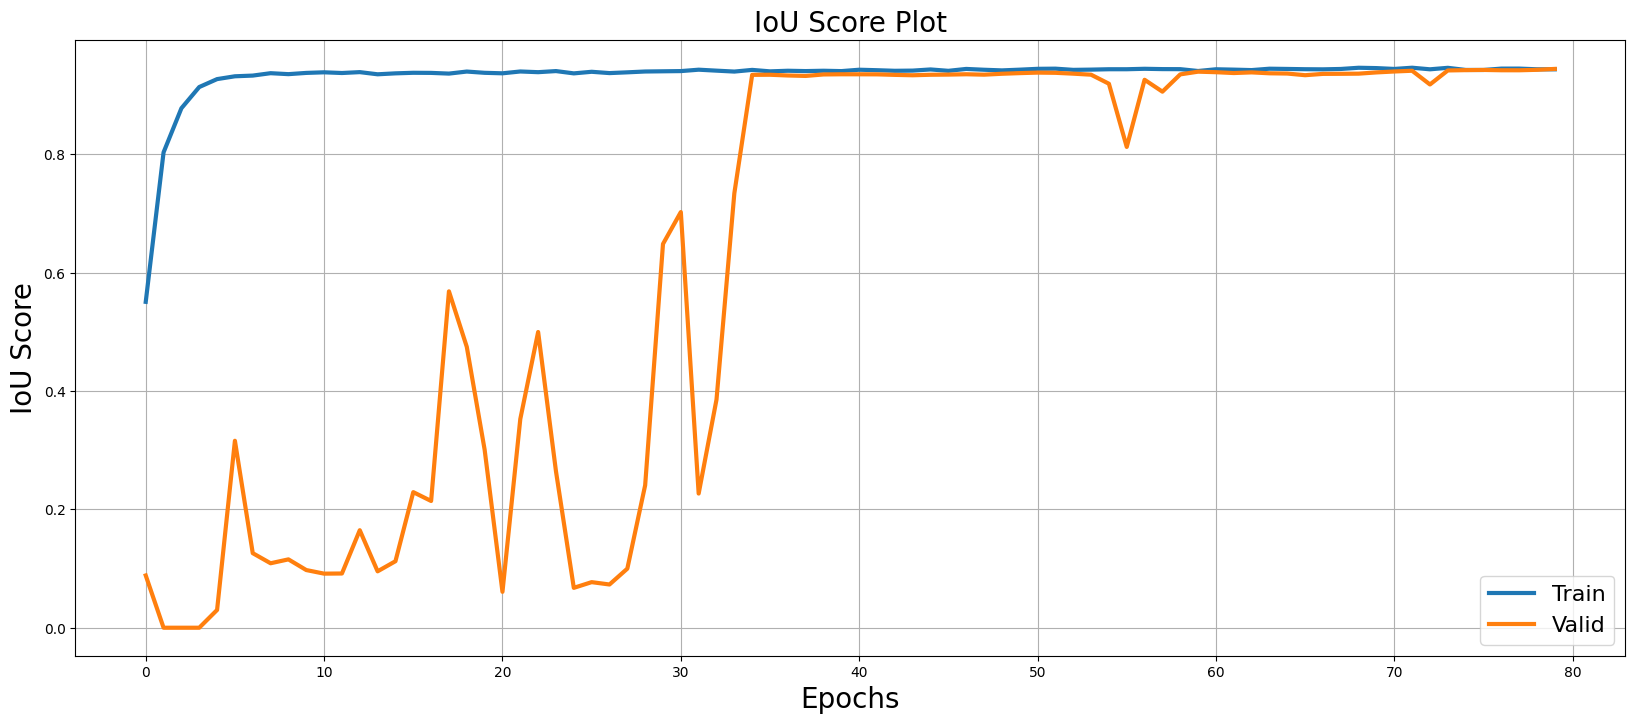

In [21]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('./sample_predictions/iou_score_plot.png')
plt.show()

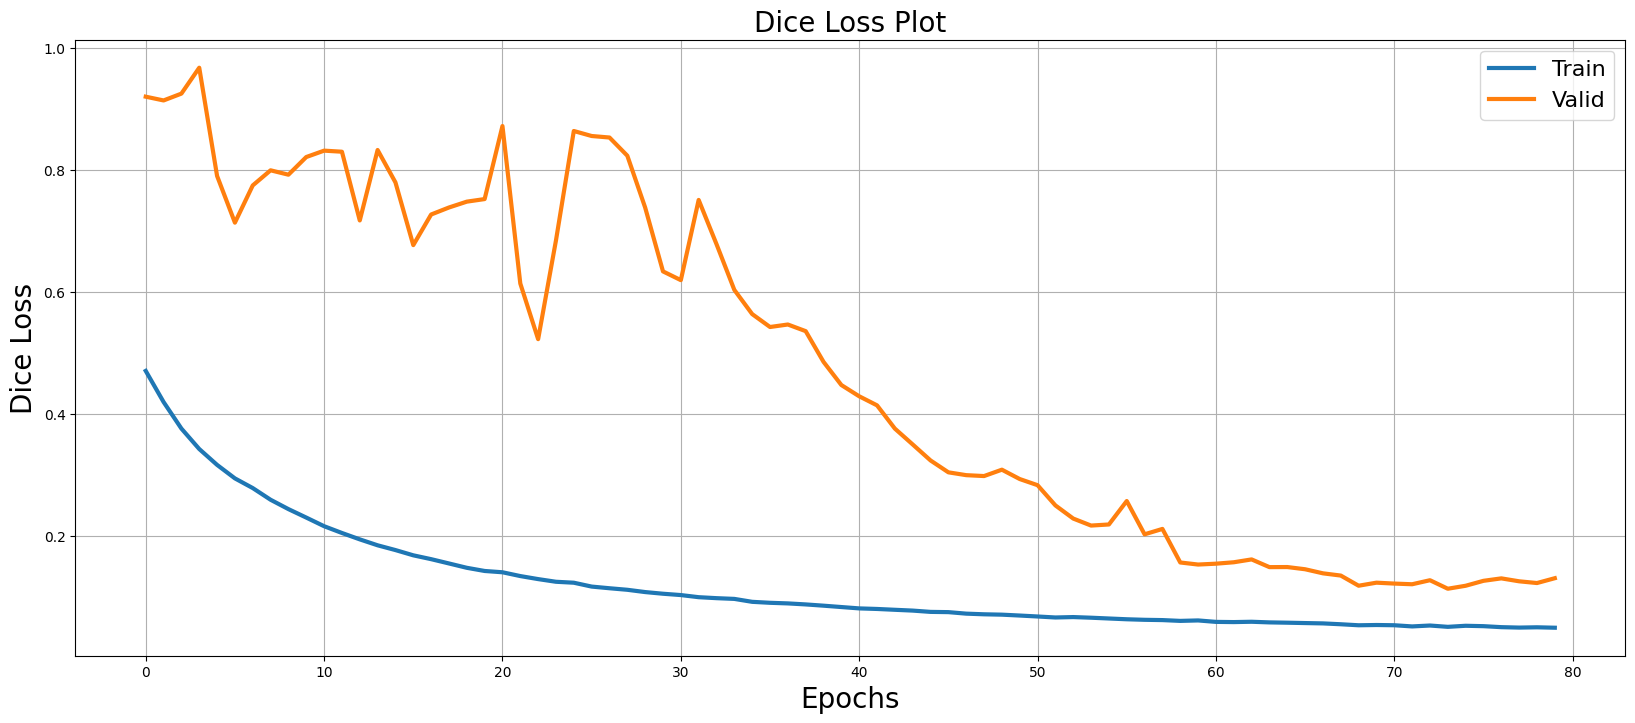

In [22]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Loss Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('./sample_predictions/dice_loss_plot.png')
plt.show()